# AVI-DYS Time Series Classification

## Import Libraries

In [41]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set User specific parameters

In [42]:
IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

data_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Post-Processing\\5-Concatenated"

save_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Confusion-Matrices\\Two-Classes"

### Create a function for predict the DIS-Scores using HIVE-COTE V2 as the classifier

In [43]:
def predict_DIS(Measure, X, Y, class_names, save_path):
    """Use HIVE-COTE V2 to predict DIS-Scores from movement and skeleton data.

    Args:
        Measure (str): Dystonia-Duration, Dystonia-Amplitude, Choreoathetosis-Duration, or Choreoathetosis-Amplitude
        X (ndarray): 3D numpy array (observations, features, time-points)
        Y (DataFrame): DataFrame containing DIS-Scores as columns
        class_names (list): list of DIS-Score classes
        save_path (str): path to folder where Confusion Matrices will be saved
    """

    # Get the relevant column from the outcome measures
    y = Y[Measure].astype(str).to_numpy()

    # Split the data using a 70-30 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

    # Create the classifier
    hc2 =HIVECOTEV2(
        stc_params=None,
        drcif_params=None,
        arsenal_params=None,
        tde_params=None,
        time_limit_in_minutes=2,
        save_component_probas=False,
        verbose=1,
        n_jobs=-1,
        random_state=42,
    )

    # Fit the classifier
    hc2.fit(X_train,y_train)

    # Predict the test labels
    y_pred = hc2.predict(X_test)

    # Create the confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
    )
    disp.ax_.set_title(Measure)
    accuracy = round(accuracy_score(y_test, y_pred) * 100, ndigits=2)
    disp.ax_.annotate(f'Accuracy = {accuracy}%',xy = (0.0, -.15),
           xycoords='axes fraction',
           ha='left',
           va="center",
           fontsize='medium',
           family='serif',
           wrap=True)

    # Save the confusion matrix
    png = str(os.path.join(save_path,f"{Measure}.png"))
    svg = str(os.path.join(save_path,f"{Measure}.svg"))
    plt.savefig(png,bbox_inches='tight',dpi=400)
    plt.savefig(svg,bbox_inches='tight')

    # Print the confusion matrix
    print('\n')
    print('Confusion Matrix')
    print(disp.confusion_matrix)

    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=class_names))

## Format the DIS Scores

Initialize an output DataFrame for the DIS scores (y)

In [44]:
# Make a list of columns for each DIS type of DIS score
cols = ['Dystonia-Duration', 'Dystonia-Amplitude',
       'Choreoathetosis-Duration', 'Choreoathetosis-Amplitude']

# Create a list of iterables for the Multindex
iterables = [IDs, ["11", "12"]]

# Create the Multindex
index = pd.MultiIndex.from_product(iterables, names=["ID", "Side Code"])

# Make a an empty data frame for the DIS scores (Y)
Y = pd.DataFrame(index=index, columns=cols)

# Reset the multindex as columns for indexing
Y.reset_index(inplace=True)

Put the DIS scores into a tidy format

In [45]:
# Read in the meta data
df = pd.read_excel("C:\\Users\\zacha\\Repos\\AVI-DYS\\DIS-Included.xlsx")

# Convert the scores from the meta data from wide to long (one row = one observation left or right)
for idx, i in enumerate(IDs):
    Y['Dystonia-Duration'][idx*2] = df['Dystonia-Right-Duration-11'][idx]
    Y['Dystonia-Duration'][idx*2+1] = df['Dystonia-Left-Duration-12'][idx]
    Y['Dystonia-Amplitude'][idx*2] = df['Dystonia-Right-Amplitude-11'][idx]
    Y['Dystonia-Amplitude'][idx*2+1] = df['Dystonia-Left-Amplitude-12'][idx]
    Y['Choreoathetosis-Duration'][idx*2] = df['Choreoathetosis-Right-Duration-11'][idx]
    Y['Choreoathetosis-Duration'][idx*2+1] = df['Choreoathetosis-Left-Duration-12'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2] = df['Choreoathetosis-Right-Amplitude-11'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2+1] = df['Choreoathetosis-Left-Amplitude-12'][idx]

# Collapse scores: DIS 1 & 2 to 1, DIS 3 & 4 to 2
for c in cols:
    Y.loc[Y[c] == 2, c] = 1
    Y.loc[Y[c] == 3, c] = 1
    Y.loc[Y[c] == 4, c] = 1

## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [46]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [47]:
for i in IDs:
   
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [48]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE v2.0

In [49]:
# Create a list of DIS categories for the confusion matrices and the classifaction report
class_names = ['DIS-0','DIS-1/2/3/4']

#### Predict the Dystonia Duration Scores

STC  22:56:25 29/05/2023
STC train estimate  22:57:06 29/05/2023
STC weight = 0.6949696434761167
DrCIF  22:57:44 29/05/2023
DrCIF train estimate  22:57:52 29/05/2023
DrCIF weight = 0.4656965919933105
Arsenal  22:58:27 29/05/2023
Arsenal train estimate  22:58:45 29/05/2023
Arsenal weight = 0.5166864844679657
TDE  22:59:07 29/05/2023
TDE train estimate  22:59:07 29/05/2023
TDE weight = 0.6311086027422714


Confusion Matrix
[[ 2  1]
 [ 0 17]]
              precision    recall  f1-score   support

       DIS-0       1.00      0.67      0.80         3
 DIS-1/2/3/4       0.94      1.00      0.97        17

    accuracy                           0.95        20
   macro avg       0.97      0.83      0.89        20
weighted avg       0.95      0.95      0.95        20



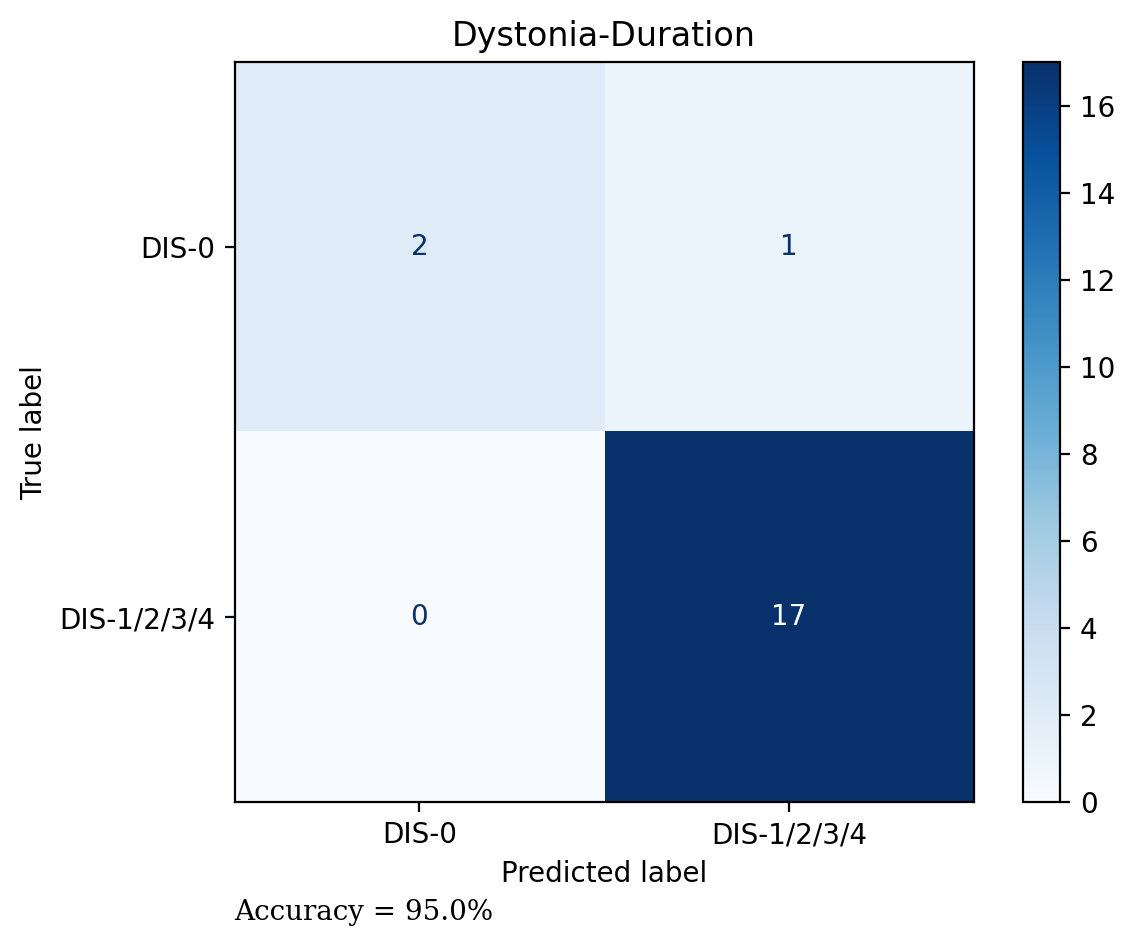

In [50]:
predict_DIS('Dystonia-Duration',X,Y,class_names,save_path)

#### Predict the Dystonia Amplitude Scores

STC  23:01:45 29/05/2023
STC train estimate  23:02:25 29/05/2023
STC weight = 0.6949696434761167
DrCIF  23:02:48 29/05/2023
DrCIF train estimate  23:02:53 29/05/2023
DrCIF weight = 0.4656965919933105
Arsenal  23:03:30 29/05/2023
Arsenal train estimate  23:03:58 29/05/2023
Arsenal weight = 0.5166864844679657
TDE  23:04:34 29/05/2023
TDE train estimate  23:04:34 29/05/2023
TDE weight = 0.5166864844679657


Confusion Matrix
[[ 2  1]
 [ 0 17]]
              precision    recall  f1-score   support

       DIS-0       1.00      0.67      0.80         3
 DIS-1/2/3/4       0.94      1.00      0.97        17

    accuracy                           0.95        20
   macro avg       0.97      0.83      0.89        20
weighted avg       0.95      0.95      0.95        20



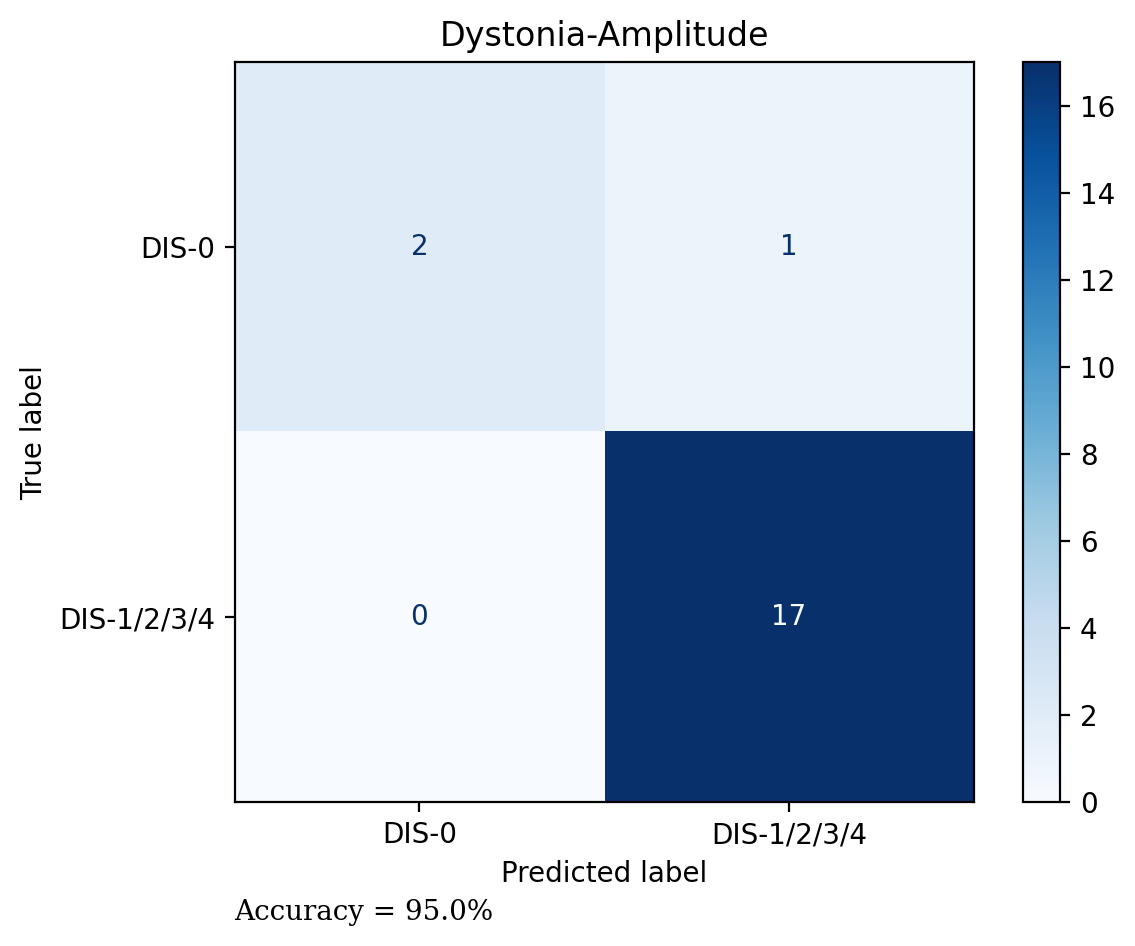

In [51]:
predict_DIS('Dystonia-Amplitude',X,Y,class_names,save_path)

#### Predict the Choreoathetosis Duration Scores

STC  23:06:57 29/05/2023
STC train estimate  23:07:35 29/05/2023
STC weight = 0.2984587676573482
DrCIF  23:08:00 29/05/2023
DrCIF train estimate  23:08:07 29/05/2023
DrCIF weight = 0.15796492472511178
Arsenal  23:08:50 29/05/2023
Arsenal train estimate  23:09:16 29/05/2023
Arsenal weight = 0.26486491436208415
TDE  23:09:40 29/05/2023
TDE train estimate  23:09:40 29/05/2023
TDE weight = 0.33515125553439284


Confusion Matrix
[[ 0  5]
 [ 2 13]]
              precision    recall  f1-score   support

       DIS-0       0.00      0.00      0.00         5
 DIS-1/2/3/4       0.72      0.87      0.79        15

    accuracy                           0.65        20
   macro avg       0.36      0.43      0.39        20
weighted avg       0.54      0.65      0.59        20



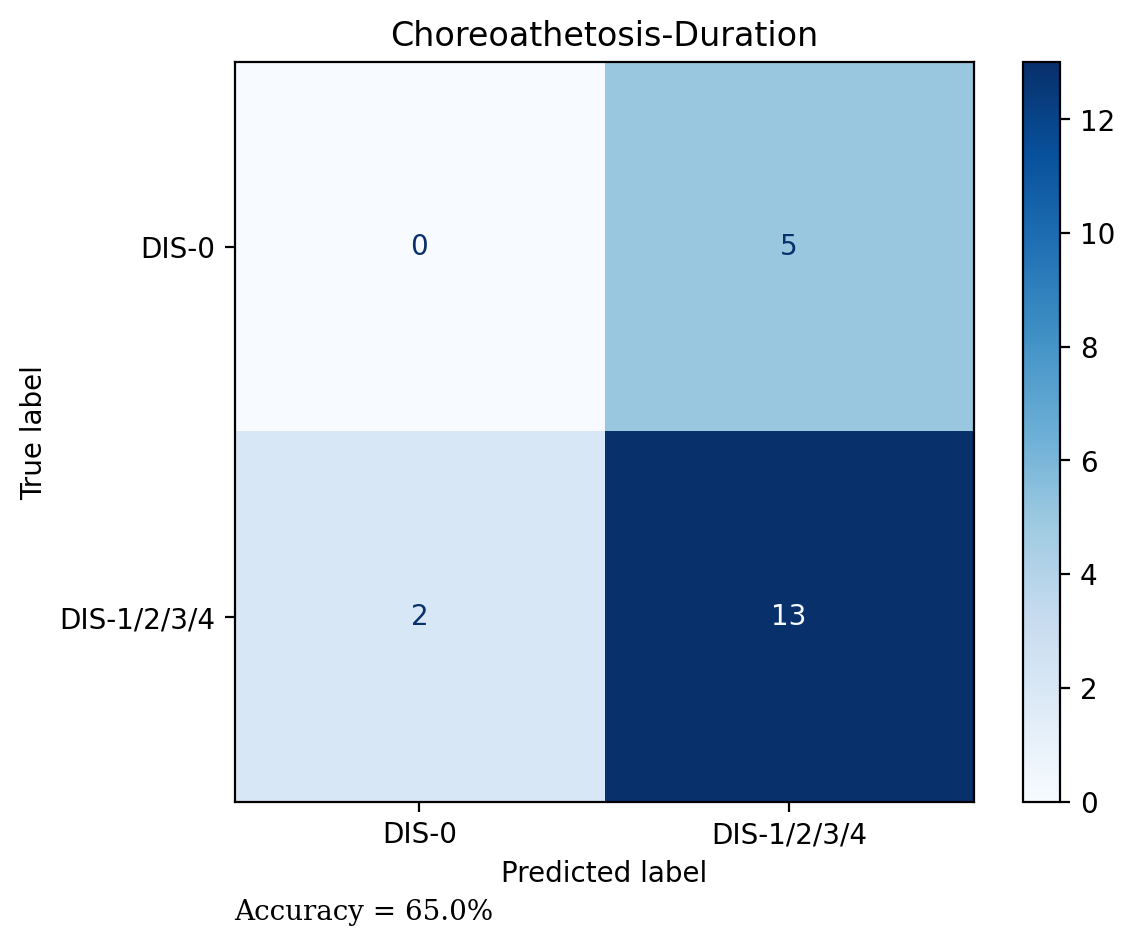

In [52]:
predict_DIS('Choreoathetosis-Duration',X,Y,class_names,save_path)

#### Predict the Choreoathetosis Amplitude Scores

STC  23:11:54 29/05/2023
STC train estimate  23:12:36 29/05/2023
STC weight = 0.23419012939490635
DrCIF  23:12:58 29/05/2023
DrCIF train estimate  23:13:03 29/05/2023
DrCIF weight = 0.15796492472511178
Arsenal  23:13:34 29/05/2023
Arsenal train estimate  23:13:50 29/05/2023
Arsenal weight = 0.26486491436208415
TDE  23:14:11 29/05/2023
TDE train estimate  23:14:11 29/05/2023
TDE weight = 0.33515125553439284


Confusion Matrix
[[ 0  5]
 [ 1 14]]
              precision    recall  f1-score   support

       DIS-0       0.00      0.00      0.00         5
 DIS-1/2/3/4       0.74      0.93      0.82        15

    accuracy                           0.70        20
   macro avg       0.37      0.47      0.41        20
weighted avg       0.55      0.70      0.62        20



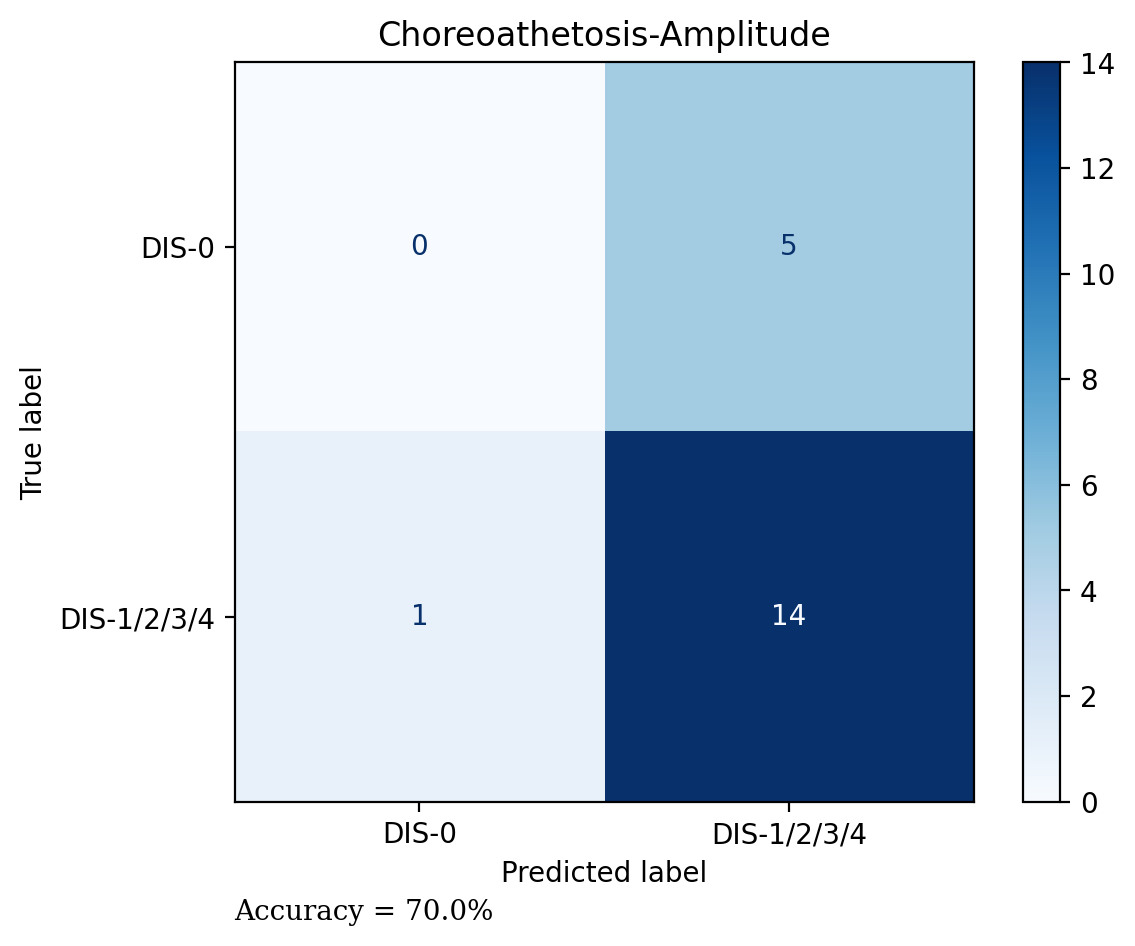

In [53]:
predict_DIS('Choreoathetosis-Amplitude',X,Y,class_names,save_path)